## **Exploratory Data Analysis**

### **Library Imports**

In [23]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = None

### **Constants**

In [4]:
DATA_PATH = os.path.join('..', 'data', 'dev', '01_raw', 'diabetic_data.csv')

### **Data Imports**

In [7]:
raw_data = pd.read_csv(DATA_PATH)
display(raw_data.head())

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,NaN,NaN,No,No,0
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,Ch,Yes,1
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,Yes,0
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,Ch,Yes,0
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,NaN,NaN,Ch,Yes,0


### **EDA**

In [76]:
raw_data.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [59]:
data = raw_data.copy()

In [60]:
data.shape

(101766, 27)

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 27 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [62]:
data = data.replace('?', np.nan)
display(data.isnull().sum().sort_values(ascending=False))

# too many missing values
# weight                      98569
# max_glu_serum               96420
# A1Cresult                   84748
# medical_specialty           49949
# payer_code                  40256 => not insured, not really a null


data = data.drop(columns=[
    'weight',
    'max_glu_serum',
    'A1Cresult',
    'medical_specialty',
])

weight                      98569
max_glu_serum               96420
A1Cresult                   84748
medical_specialty           49949
payer_code                  40256
race                         2273
diag_3                       1423
diag_2                        358
diag_1                         21
encounter_id                    0
number_emergency                0
diabetesMed                     0
change                          0
number_diagnoses                0
number_inpatient                0
num_procedures                  0
number_outpatient               0
num_medications                 0
patient_nbr                     0
num_lab_procedures              0
time_in_hospital                0
admission_source_id             0
discharge_disposition_id        0
admission_type_id               0
age                             0
gender                          0
readmitted                      0
dtype: int64

In [64]:
data.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [66]:
ID_COLS = [
    'encounter_id',
    'patient_nbr'
]

TARGET_COL = 'readmitted'

NUMERIC_COLS = [
    'time_in_hospital',
    'num_lab_procedures',
    'num_procedures',
    'num_medications',
    'number_outpatient',
    'number_emergency',
    'number_inpatient',
    'number_diagnoses',
]

CATEGORICAL_COLS = [
    'race',
    'gender',
    'age',
    'payer_code',
    'admission_type_id',     
    'discharge_disposition_id',  
    'admission_source_id',        
    'payer_code',                
    'diag_1',                    
    'diag_2',                    
    'diag_3',      
    'change',                    
    'diabetesMed',  
]

for col in CATEGORICAL_COLS:
    data[col] = data[col].astype('category')

for col in NUMERIC_COLS:
    data[col] = data[col].astype('float')

In [67]:
id_data = data[ID_COLS].copy()
target_data = data[TARGET_COL].copy()
num_data = data[NUMERIC_COLS].copy()
cat_data = data[CATEGORICAL_COLS].copy()

#### **Target**

In [68]:
target_data.value_counts(1)

readmitted
0    0.539119
1    0.460881
Name: proportion, dtype: float64

#### **IDs**

In [24]:
id_data.nunique()

# encounter_id is unique
# patient_nbr is not unique

encounter_id    101766
patient_nbr      71518
dtype: int64

In [32]:
(id_data.groupby('patient_nbr').count()
 .sort_values('encounter_id', ascending=False)
 .head(10))

,encounter_id
patient_nbr,
88785891,40
43140906,28
1660293,23
23199021,23
88227540,23
23643405,22
84428613,22
92709351,21
23398488,20


#### **Numeric**

In [69]:
num_data.describe().T

,count,mean,std,min,25%,50%,75%,max
time_in_hospital,101766.0,4.395987,2.985108,1.0,2.0,4.0,6.0,14.0
num_lab_procedures,101766.0,43.095641,19.674362,1.0,31.0,44.0,57.0,132.0
num_procedures,101766.0,1.339730,1.705807,0.0,0.0,1.0,2.0,6.0
num_medications,101766.0,16.021844,8.127566,1.0,10.0,15.0,20.0,81.0
number_outpatient,101766.0,0.369357,1.267265,0.0,0.0,0.0,0.0,42.0
number_emergency,101766.0,0.197836,0.930472,0.0,0.0,0.0,0.0,76.0
number_inpatient,101766.0,0.635566,1.262863,0.0,0.0,0.0,1.0,21.0
number_diagnoses,101766.0,7.422607,1.933600,1.0,6.0,8.0,9.0,16.0


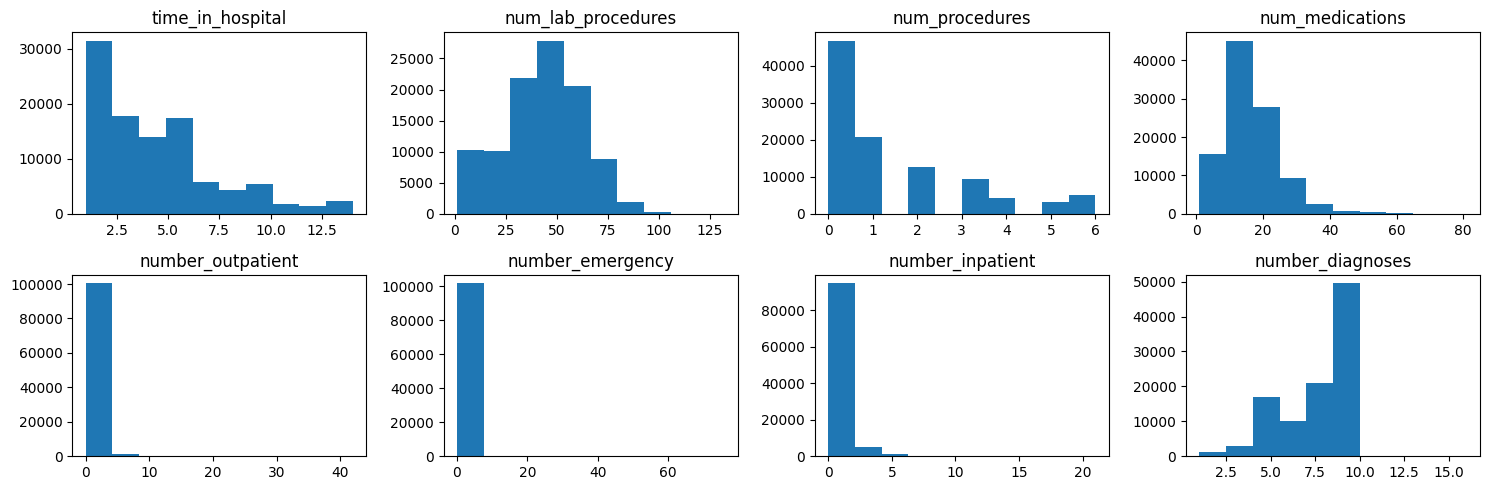

In [73]:
plt.figure(figsize=(15, 5))
for i, col in enumerate(NUMERIC_COLS):
   plt.subplot(2, 4, i + 1)
   plt.hist(num_data[col])
   plt.title(col)

plt.tight_layout()
plt.show()

#### **Categorical**

In [75]:
cat_data.describe().T

,count,unique,top,freq
race,99493,5,Caucasian,76099
gender,101766,3,Female,54708
age,101766,10,[70-80),26068
payer_code,61510,17,MC,32439
admission_type_id,101766,8,1,53990
discharge_disposition_id,101766,26,1,60234
admission_source_id,101766,17,7,57494
payer_code,61510,17,MC,32439
diag_1,101745,716,428,6862
diag_2,101408,748,276,6752


In [77]:
cat_data['age'].value_counts()

age
[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: count, dtype: int64

#### **Mixed-Data Analysis**